In [21]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib

sns.set_style("whitegrid")


In [22]:
def load_data():
    csvs = [f for f in os.listdir() if f.lower().endswith(".csv")]
    if len(csvs) == 1:
        return pd.read_csv(csvs[0])
    elif len(csvs) > 1:
        print("Multiple CSVs found, using the first one:", csvs[0])
        return pd.read_csv(csvs[0])
    else:
        raise FileNotFoundError("No CSV file found in current directory. Upload the data and retry.")

data = load_data()
print("Shape:", data.shape)
display(data.head())
display(data.info())


Shape: (21613, 21)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7229300521,20141013T000000,231300.0,2,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

None

,price
count,2.161300e+04
mean,5.400886e+05
std,3.671268e+05
min,7.500000e+04
25%,3.219500e+05
50%,4.500000e+05
75%,6.450000e+05
max,7.700000e+06


Skewness: 4.024080394890599


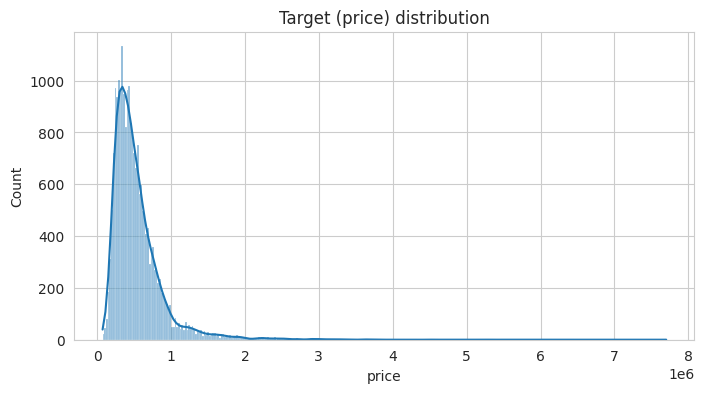

In [23]:
target_col = "price"
if target_col not in data.columns:
    raise KeyError(f"Target column '{target_col}' not found. Update target_col variable.")

display(data[target_col].describe())

print("Skewness:", data[target_col].skew())

plt.figure(figsize=(8,4))
sns.histplot(data[target_col], kde=True)
plt.title("Target (price) distribution")
plt.show()


In [24]:
missing = data.isnull().sum().sort_values(ascending=False)
display(missing[missing > 0])



,0


In [25]:

numeric_features = data.select_dtypes(include=[np.number]).columns.tolist()
numeric_features.remove(target_col)
categorical_features = data.select_dtypes(include=["object", "category"]).columns.tolist()

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)


Numeric features: ['id', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']
Categorical features: ['date']


In [26]:
X = data.drop(columns=[target_col])
y = data[target_col].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (17290, 20) Test shape: (4323, 20)


In [29]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
], remainder="drop")


In [30]:
lr_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])

rf_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(random_state=42, n_jobs=-1))
])


In [31]:
lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

print("Linear Regression -- RMSE:", rmse(y_test, y_pred_lr))
print("Linear Regression -- R2:", r2_score(y_test, y_pred_lr))

cv_scores = cross_val_score(lr_pipeline, X, y, scoring="neg_root_mean_squared_error", cv=5)
print("LR CV RMSE (5-fold):", -np.mean(cv_scores), "±", np.std(cv_scores))


Linear Regression -- RMSE: 214181.61643576174
Linear Regression -- R2: 0.6965553481471802
LR CV RMSE (5-fold): 203446.31443113688 ± 10089.523776848428


In [32]:
rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)

print("Random Forest (default) -- RMSE:", rmse(y_test, y_pred_rf))
print("Random Forest (default) -- R2:", r2_score(y_test, y_pred_rf))

cv_scores_rf = cross_val_score(rf_pipeline, X, y, scoring="neg_root_mean_squared_error", cv=5)
print("RF CV RMSE (5-fold):", -np.mean(cv_scores_rf), "±", np.std(cv_scores_rf))


Random Forest (default) -- RMSE: 148205.03489899932
Random Forest (default) -- R2: 0.8547082282614107
RF CV RMSE (5-fold): 130647.42883904534 ± 6986.298756508501


In [33]:
param_grid = {
    "regressor__n_estimators": [100, 200],
    "regressor__max_depth": [None, 10, 20],
    "regressor__min_samples_leaf": [1, 2, 4]
}

grid = GridSearchCV(rf_pipeline, param_grid, cv=3, scoring="neg_root_mean_squared_error", n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)
print("Best CV RMSE:", -grid.best_score_)

best_rf = grid.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)
print("Tuned RF -- Test RMSE:", rmse(y_test, y_pred_best_rf))
print("Tuned RF -- Test R2:", r2_score(y_test, y_pred_best_rf))


Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best params: {'regressor__max_depth': 20, 'regressor__min_samples_leaf': 1, 'regressor__n_estimators': 200}
Best CV RMSE: 128864.56106956101
Tuned RF -- Test RMSE: 147152.2093568942
Tuned RF -- Test R2: 0.8567651565154797


,feature,importance
9,grade,0.317859
3,sqft_living,0.268415
15,lat,0.150922
16,long,0.060161
12,yr_built,0.031912
6,waterfront,0.031268
17,sqft_living15,0.028505
10,sqft_above,0.016579
14,zipcode,0.013403
2,bathrooms,0.011616


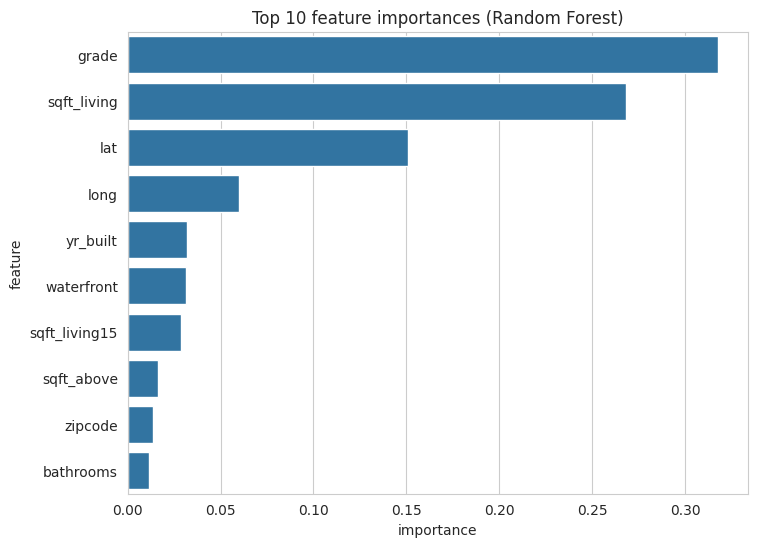

In [34]:
preproc = best_rf.named_steps["preprocessor"]
# numeric names
num_names = numeric_features
if categorical_features:
    ohe = preproc.named_transformers_["cat"].named_steps["onehot"]
    cat_names = list(ohe.get_feature_names_out(categorical_features))
else:
    cat_names = []

feature_names = num_names + cat_names

importances = best_rf.named_steps["regressor"].feature_importances_
fi_df = pd.DataFrame({"feature": feature_names, "importance": importances}).sort_values("importance", ascending=False)
display(fi_df.head(20))

# Plot top 10
plt.figure(figsize=(8,6))
sns.barplot(data=fi_df.head(10), x="importance", y="feature")
plt.title("Top 10 feature importances (Random Forest)")
plt.show()


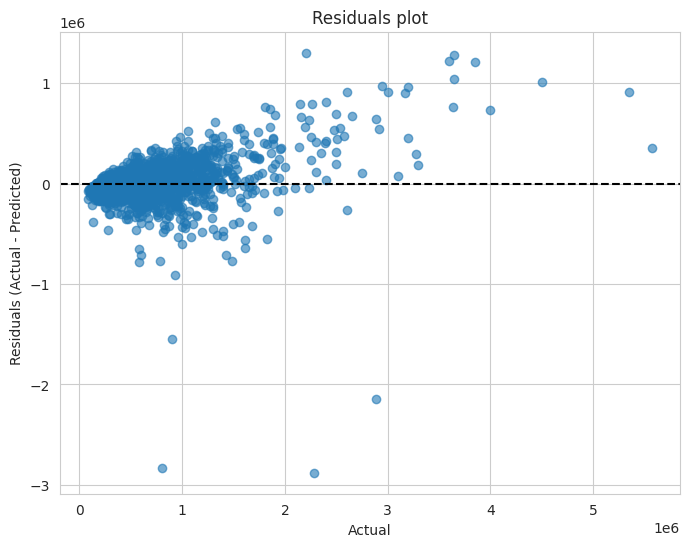

In [35]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_test - y_pred_best_rf, alpha=0.6)
plt.axhline(0, color="k", linestyle="--")
plt.xlabel("Actual")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals plot")
plt.show()


In [36]:
joblib.dump(best_rf, "best_house_price_model.joblib")
print("Saved model to best_house_price_model.joblib")


Saved model to best_house_price_model.joblib


In [40]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=200,
        max_depth=20,
        min_samples_leaf=2,
        random_state=42
    ))
])

pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['id', 'bedrooms',
                                                   'bathrooms', 'sqft_living',
                                                   'sqft_lot', 'floors',
                                                   'waterfront', 'view',
                                                   'condition', 'grade',
                                                   'sqft_above',
                                                   'sqft_basement', 'yr_built',
                                                   'yr_renovated', 'zipcode',
                                                   'lat', 'long',
                                                   'sqft_living15',
                                                   'sqft_lot15']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['date'])])),
                ('regressor',
                 RandomForestRegressor(max_depth=20, min_samples_leaf=2,
                                       n_estimators=200, random_state=42))])

In [41]:
import joblib

joblib.dump(pipeline, "best_house_price_model.joblib")
print("✅ Model saved successfully as best_house_price_model.joblib")


✅ Model saved successfully as best_house_price_model.joblib


In [42]:
from google.colab import files
files.download("best_house_price_model.joblib")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>